# Imports

In [1]:
import numpy as np
from pathlib import Path
import pickle
import pandas as pd
from collections import Counter, defaultdict


In [8]:
is_english_movies = True
is_foreign_movies = False
only_us_produced = True
min_year = 1960
min_decade = min_year // 10 * 10

In [11]:
figure_size=(20, 16)
base_path = Path('.')
movie_ids = []

def get_us_movies_ids(df):
    return df[df['production_countries'].apply(lambda x: any([country['iso_3166_1'] == 'US' for country in x]))]["imdb_id"].values

with open(base_path/'posters_new_races4_cast_all.pkl', 'rb') as f:
   poster_face_races_new_encoding = pickle.load(f)

with open(base_path/'ranking_posters_new_races4_cast_all.pkl', 'rb') as f:
   posters_for_ranking_graphs = pickle.load(f)

with open('/data/Posters/data/metadata/tmdb_data.pkl', 'rb') as f:
   tmdb_data = pickle.load(f)

with open(base_path/'races_actors.pkl', 'rb') as f:
   races_actors = pickle.load(f)



en_movies = list(tmdb_data[tmdb_data['original_language'] == 'en']['imdb_id'])
non_en_movies = list(tmdb_data[tmdb_data['original_language'] != 'en']['imdb_id'])

if is_english_movies:
    movie_ids += en_movies

if is_foreign_movies:
    print("Added foreign movies.")
    movie_ids += non_en_movies

# Filter out movies that are not produced in the US
if only_us_produced:
      print("Added only US produced movies.")
      movie_ids = list(set(movie_ids) & set(get_us_movies_ids(tmdb_data)))



posters_for_ranking_graphs = posters_for_ranking_graphs.drop_duplicates()
poster_face_races_new_encoding = poster_face_races_new_encoding.drop_duplicates(subset='file_path')


poster_face_races_new_encoding = poster_face_races_new_encoding[poster_face_races_new_encoding['tconst'].isin(movie_ids)]
posters_for_ranking_graphs = posters_for_ranking_graphs[posters_for_ranking_graphs['tconst'].isin(movie_ids)]

Added english movies.
Added only US produced movies.


In [18]:
tmdb_data["year"] = tmdb_data["year"].replace("",np.nan).astype(float)

<AxesSubplot:>

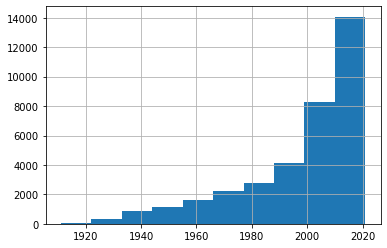

In [19]:
tmdb_data["year"].hist()

In [57]:
min(set(poster_face_races_new_encoding.decade))

1910.0

<AxesSubplot:>

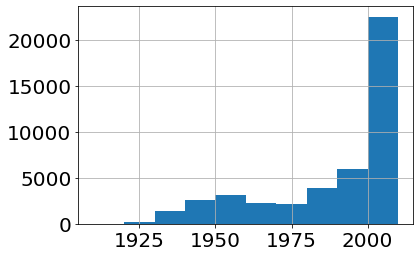

In [59]:
poster_face_races_new_encoding.decade.hist(bins=range(1910, 2020, 10))

<AxesSubplot:>

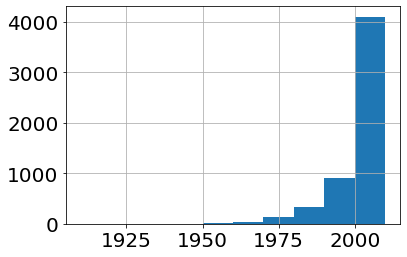

In [61]:
poster_face_races_new_encoding[poster_face_races_new_encoding.Black>0].decade.hist(bins=range(1910, 2020, 10))

<AxesSubplot:>

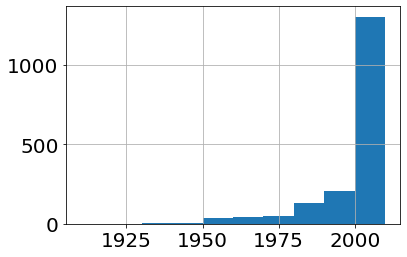

In [62]:
poster_face_races_new_encoding[poster_face_races_new_encoding.Asian>0].decade.hist(bins=range(1910, 2020, 10))

<AxesSubplot:>

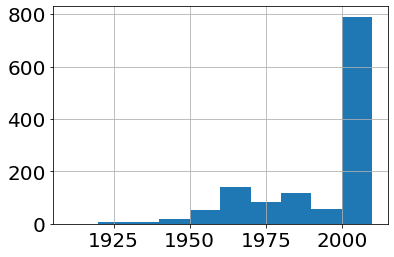

In [63]:
poster_face_races_new_encoding[poster_face_races_new_encoding.Indian>0].decade.hist(bins=range(1910, 2020, 10))

# Preparing Data For Graphs 

In [14]:
poster_face_races_new_encoding["decade"] = poster_face_races_new_encoding['startYear']//10 *10

In [15]:
posters_races_df = poster_face_races_new_encoding[poster_face_races_new_encoding['startYear'] >= min_year]

In [16]:
posters_faces_df_exploded = posters_races_df.explode("face_percentage")
posters_faces_df_exploded["faces_races"] = posters_races_df.explode("faces_races")["faces_races"]

In [17]:
def get_max_n(poster_faces, n=1):
  return poster_faces.sort_values(by="face_percentage", ascending=False).head(n)

posters_max_faces_df = posters_faces_df_exploded.groupby(posters_faces_df_exploded.index).apply(get_max_n).reset_index(0)
posters_max_faces_df['face_percentage'] = posters_max_faces_df['face_percentage'].astype(float)

In [18]:
posters_faces_df_exploded["face_percentage_relative"] = posters_races_df.explode("face_percentage_relative")["face_percentage_relative"]
posters_faces_df_exploded['face_percentage_relative'] = posters_faces_df_exploded['face_percentage_relative'].astype(float)

In [19]:
import seaborn as sns

colors = sns.color_palette()
palette = {"White": colors[0], "Black": colors[1], "Asian": colors[2], "Indian": colors[3]}
hue_order = ['Asian', 'Black', 'Indian', 'White']

In [20]:
#            l    t   r   d 
from scipy.spatial import distance

def calc_euclidian_distance(row):
  poster_center = row['width']/2, row['height']/2
  diagonal = distance.euclidean(poster_center, (0,0))
  result = []
  for box in row['boxes']:
    (l,t,r,d) = box
    face_center = (r-(r-l)/2, d-(d-t)/2)
    dst = distance.euclidean(poster_center, face_center)
    result.append(dst/diagonal)

  return result

def calc_w_distance(row):
  w_center = row['width']/2
  result = []
  for box in row['boxes']:
    (l,t,r,d) = box
    dst = abs(r - w_center)
    result.append(dst/w_center)

  return result


def calc_h_distance(row, pos=True):
  h_center = row['height']/2
  result = []
  for box in row['boxes']:
    (l,t,r,d) = box
    if pos:
      dst = abs(h_center - t)
    else:
      h_center - t
    result.append(dst/h_center)

  return result

  return result
posters_races_df['center_dist'] = posters_races_df.apply(calc_euclidian_distance, axis=1)
posters_races_df['h_dist'] = posters_races_df.apply(calc_h_distance, axis=1)
posters_races_df['w_dist'] = posters_races_df.apply(calc_w_distance, axis=1)
posters_races_df['norm_loc'] = posters_races_df.apply(calc_w_distance, axis=1)

/tmp/ipykernel_111641/3098244527.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posters_races_df['center_dist'] = posters_races_df.apply(calc_euclidian_distance, axis=1)
/tmp/ipykernel_111641/3098244527.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posters_races_df['h_dist'] = posters_races_df.apply(calc_h_distance, axis=1)
/tmp/ipykernel_111641/3098244527.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

# Graph of number of unique faces over decade

In [21]:
def get_races_counts(row):
  races = row["faces_races"]

  keys = Counter(races).keys()
  counts = [count for count in Counter(races).values()]

  for key, count in zip(keys,counts):
    row[key] = count

  return row

posters_races_counts_df = posters_races_df.apply(get_races_counts, axis = 1).fillna(0).drop([''], axis=1)
posters_races_counts_df['ethnic_count'] = posters_races_counts_df['Asian'] + posters_races_counts_df['Black']+posters_races_counts_df['Indian']+posters_races_counts_df['White']
posters_races_counts_df["decade"] = (posters_races_counts_df.startYear//10)*10

In [22]:
races = defaultdict(lambda : None, dict(zip(races_actors['actor_id'], races_actors['race4'])))

In [24]:
from itertools import chain
from collections import Counter

def uniqu_actors(group):
  actors = [races[int(x)] for x in set(chain.from_iterable(group['face_actor'])) if x != '']
  actors = [line for line in actors if line is not None]
  return dict(Counter(actors))

uniqe_df = posters_races_counts_df[['faces_races','face_actor', 'tconst']].groupby('tconst').apply(uniqu_actors)

In [25]:
data = uniqe_df.apply(pd.Series).fillna(0).merge(posters_races_counts_df[['tconst', 'decade', 'startYear']], on='tconst').drop_duplicates()
data['ethnic_count'] = data['Asian'] + data['Black'] + data['Indian'] + data['White']

/tmp/ipykernel_111641/3505104275.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data = uniqe_df.apply(pd.Series).fillna(0).merge(posters_races_counts_df[['tconst', 'decade', 'startYear']], on='tconst').drop_duplicates()
/tmp/ipykernel_111641/3505104275.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data = uniqe_df.apply(pd.Series).fillna(0).merge(posters_races_counts_df[['tconst', 'decade', 'startYear']], on='tconst').drop_duplicates()
/tmp/ipykernel_111641/3505104275.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data = uniqe_df.apply(pd.Series).fillna(0).merge(posters_races_counts_df[['tconst', 'decade', 'startYear']], on='t

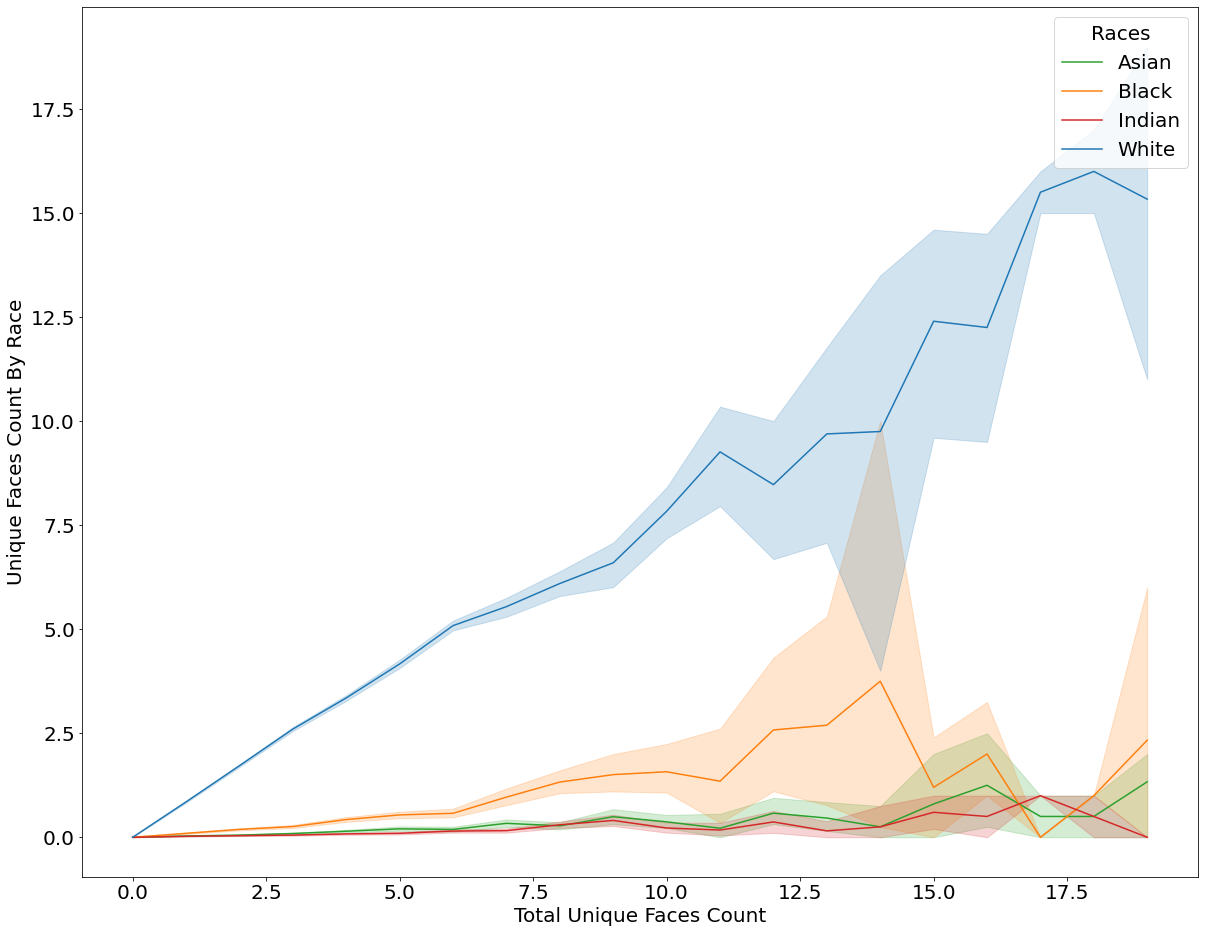

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=figure_size)
plt.rcParams.update({'font.size': 20})

data_until10 = data[data['ethnic_count']<20]
data_until10 = data_until10[data_until10['decade'] >= 2000]
race_probability_by_decade_melted = pd.melt(data_until10, id_vars=['ethnic_count', "decade"], value_vars=['White',"Black", "Indian", "Asian"])
race_probability_by_decade_melted['Decade'] = race_probability_by_decade_melted['decade'].astype(int)

ax = sns.lineplot(
    data=race_probability_by_decade_melted, x="ethnic_count", y="value", 
    hue="variable", hue_order=hue_order,  palette=palette)
ax.set(xlabel='Total Unique Faces Count', ylabel='Unique Faces Count By Race')
ax.legend().set_title('Races')

<Figure size 1440x1152 with 0 Axes>

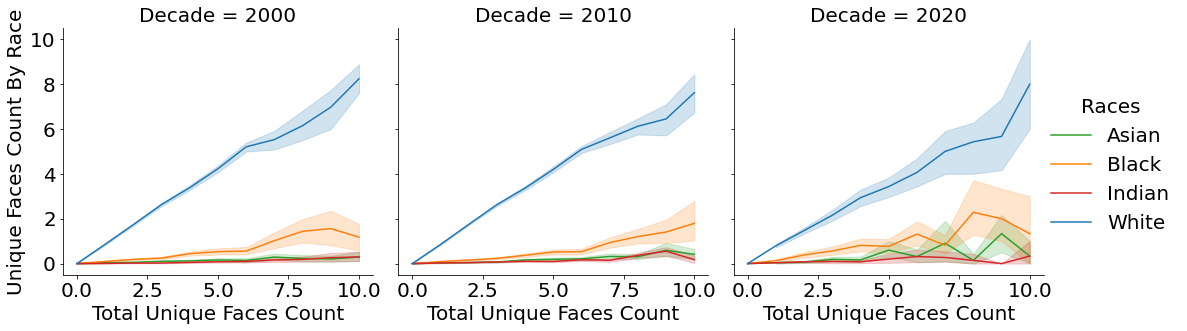

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=figure_size)
plt.rcParams.update({'font.size': 20})
import seaborn as sns

data_until10 = data[data['ethnic_count']<11]
data_until10 = data_until10[data_until10['decade'] >= 2000]
race_probability_by_decade_melted = pd.melt(data_until10, id_vars=['ethnic_count', "decade"], value_vars=['White',"Black", "Indian", "Asian"])
race_probability_by_decade_melted['Decade'] = race_probability_by_decade_melted['decade'].astype(int)
race_probability_by_decade_melted = race_probability_by_decade_melted.rename(columns={"variable":"Races"})
ax = sns.relplot(
    data=race_probability_by_decade_melted, x="ethnic_count", y="value", 
    hue="Races", hue_order=hue_order, col="Decade", palette=palette, kind="line")
ax.set(xlabel='Total Unique Faces Count', ylabel='Unique Faces Count By Race')
# ax.legend().set_title('Races')

# sns.relplot(
#     data=fmri, x="timepoint", y="signal",
#     col="region", hue="event", style="event",
#     kind="line"
# )

# Graph of distance from faces to poster center

In [28]:
def explod_poster_df(posters_races_df, params):
  posters_faces_dist_exploded = posters_races_df.explode([*params, 'faces_races'])
  for p in params:
    posters_faces_dist_exploded[p] = posters_faces_dist_exploded[p].astype(float)
  # posters_faces_dist_exploded = posters_faces_dist_exploded[["decade","faces_races","center_dist",'tconst']]
  posters_faces_dist_exploded = posters_faces_dist_exploded[posters_faces_dist_exploded["faces_races"]!=""]
  return posters_faces_dist_exploded

In [29]:
posters_faces_dist_exploded = explod_poster_df(posters_races_df, ["center_dist", "w_dist", "h_dist", "face_percentage", "face_percentage_relative"])

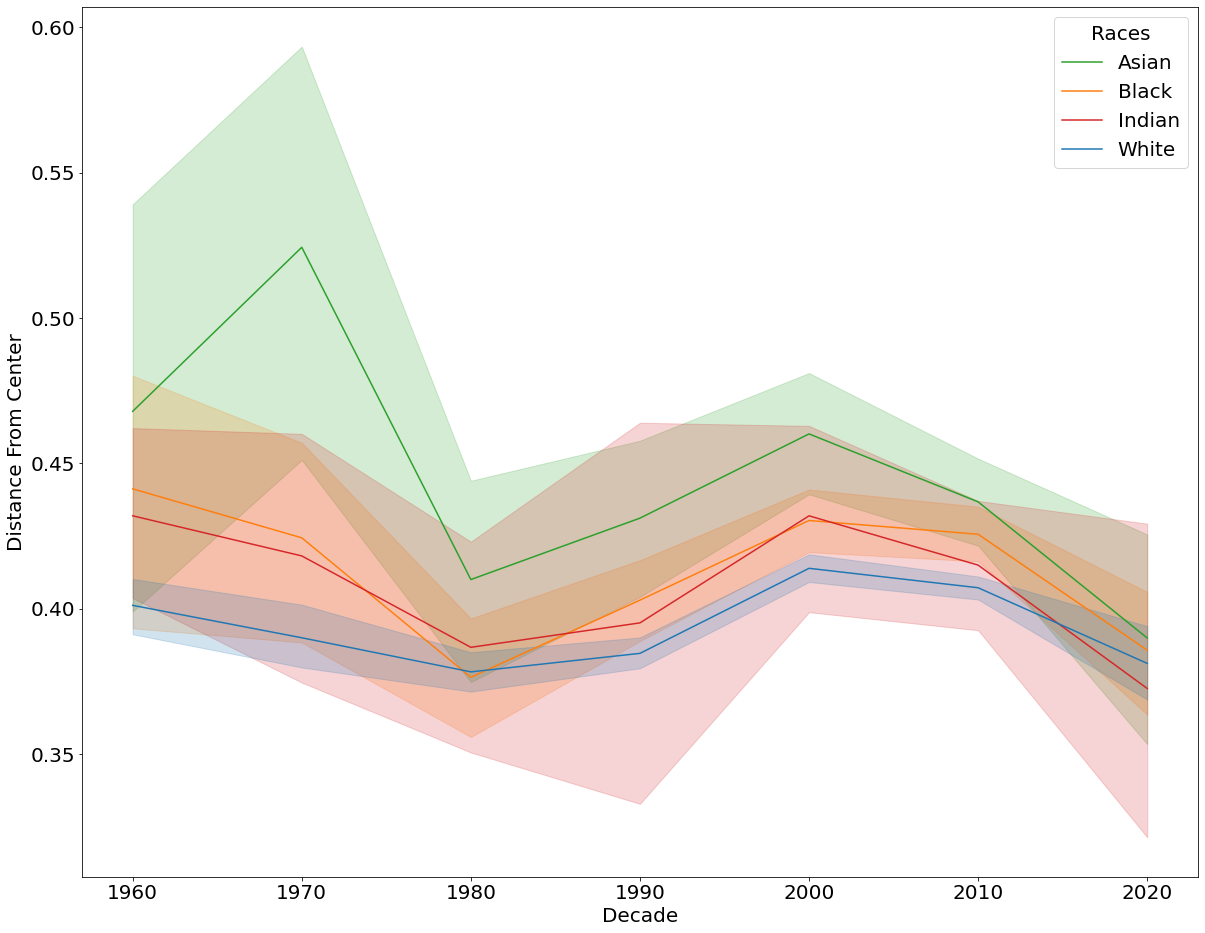

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=figure_size)
plt.rcParams.update({'font.size': 20})

# posters_faces_dist_exploded["decade"] = (posters_faces_dist_exploded.startYear//10)*10
posters_faces_dist_grouped = posters_faces_dist_exploded.groupby(['tconst','decade', 'faces_races']).mean().reset_index()

ax = sns.lineplot(data=posters_faces_dist_grouped, x="decade", y="center_dist",hue='faces_races', hue_order=hue_order, palette=palette)

ax.set(xlabel='Decade', ylabel='Distance From Center')
ax.legend().set_title('Races')

# y_ticks = [i/10 for i in range(0,60,5)]
# ax.set_yticks(y_ticks)


In [31]:
posters_faces_df_exploded["face_percentage"] = posters_faces_df_exploded["face_percentage"].astype(float)

# Grpah of **face percentage relative** over **decade**

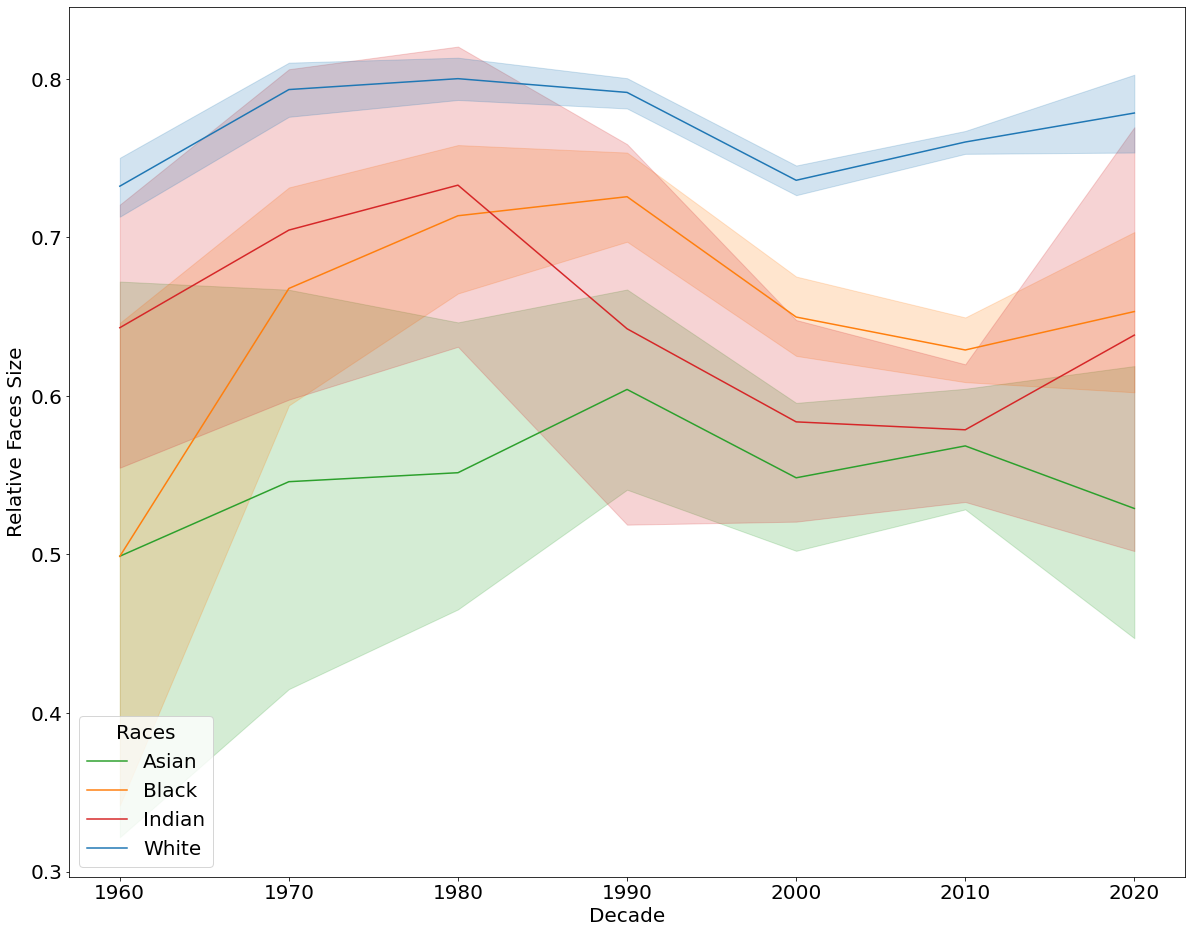

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=figure_size)
plt.rcParams.update({'font.size': 20})

import seaborn as sns

faces_count_by_year = posters_faces_df_exploded[posters_faces_df_exploded["faces_races"]!=""]
faces_count_by_year = posters_faces_df_exploded.groupby(['tconst', 'decade', 'faces_races']).mean().reset_index()
faces_count_by_year = faces_count_by_year.reset_index(drop=True)
faces_count_by_year = faces_count_by_year.sort_values(['faces_races', 'startYear'])

ax = sns.lineplot(data=faces_count_by_year, x="decade", y="face_percentage_relative", hue='faces_races', hue_order=hue_order, palette=palette)
ax.set(xlabel='Decade', ylabel='Relative Faces Size')
ax.legend().set_title('Races')

# y_ticks = [i/100 for i in range(0,105,10)]
# ax.set_yticks(y_ticks)

# Graph of **race probability** of faces in poster given the largest face race over **decade**

In [33]:
from collections import Counter

def get_races_counts(row):
  races=row["faces_races"]

  keys = Counter(races).keys()
  counts = [count for count in Counter(races).values()]

  for key, count in zip(keys,counts):
    row[key] = count

  return row

posters_races_counts_df = posters_races_df.apply(get_races_counts, axis = 1).fillna(0).drop([''], axis=1)

In [34]:
import numpy as np

def get_largest_face_race(row):
  max_index = np.argmax(row['face_percentage'])
  row['largest_face_race'] = row['faces_races'][max_index]
  return row

posters_races_counts_df = posters_races_counts_df.apply(get_largest_face_race, axis=1)

In [35]:
from collections import Counter

def update_races_counts(row):
  races=row["faces_races"]

  races_counter = Counter(races)
  races_counter[row['largest_face_race']] = races_counter[row['largest_face_race']] - 1

  keys = races_counter.keys()
  counts = [count for count in races_counter.values()]

  for key, count in zip(keys,counts):
    row[key] = count

  return row

posters_races_counts_updated_df = posters_races_counts_df.apply(update_races_counts, axis = 1).fillna(0).drop([''], axis=1)

In [36]:
posters_races_counts_updated_df['ethnic_count'] = posters_races_counts_updated_df['Asian'] + posters_races_counts_updated_df['Black']+posters_races_counts_updated_df['Indian']+posters_races_counts_updated_df['White']

In [37]:
posters_races_counts_updated_df = posters_races_counts_updated_df[posters_races_counts_updated_df['ethnic_count'] > 0]

def calc_races_ratio(row):
  row['Asian'] = row['Asian'] / (row['ethnic_count'])
  row['Black'] = row['Black'] / (row['ethnic_count'])
  row['Indian'] = row['Indian'] / (row['ethnic_count'])
  row['White'] = row['White'] / (row['ethnic_count'])

  return row
posters_races_counts_updated_df = posters_races_counts_updated_df.apply(calc_races_ratio, axis=1)

<Figure size 1440x1152 with 0 Axes>

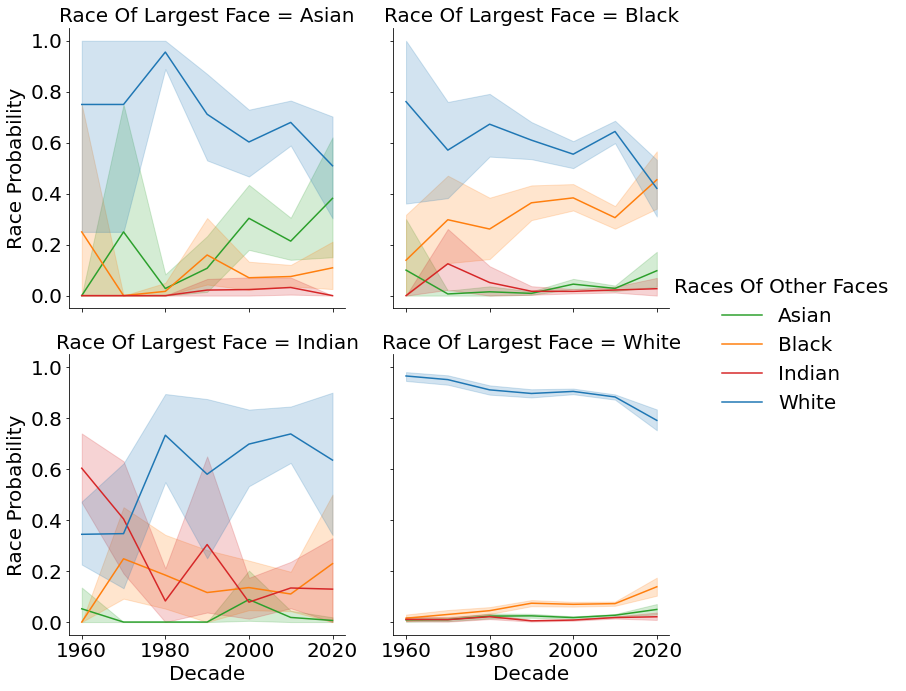

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=figure_size)
plt.rcParams.update({'font.size': 20})
import seaborn as sns

race_probability_given_largest_race_by_decade = posters_races_counts_updated_df.groupby(['decade','largest_face_race', "tconst"]).mean()[['White', 'Black', 'Indian', 'Asian']]
# race_probability_given_largest_race_by_decade_melted = pd.melt(race_probability_given_largest_race_by_decade.reset_index(), id_vars=['largest_face_race', "startYear"], value_vars=['White',"Black", "Indian", "Asian"])
race_probability_given_largest_race_by_decade_melted = pd.melt(race_probability_given_largest_race_by_decade.reset_index(), id_vars=['largest_face_race', "decade"], value_vars=['White',"Black", "Indian", "Asian"])
race_probability_given_largest_race_by_decade_melted['Race Of Largest Face'] = race_probability_given_largest_race_by_decade_melted['largest_face_race']
race_probability_given_largest_race_by_decade_melted['Races Of Other Faces'] = race_probability_given_largest_race_by_decade_melted['variable']

# race_probability_given_largest_race_by_decade_melted = race_probability_given_largest_race_by_decade_melted.groupby(['decade', 'Race Of Largest Face', 'Races Of Other Faces']).mean().reset_index()
race_probability_given_largest_race_by_decade_melted = race_probability_given_largest_race_by_decade_melted.sort_values(['Race Of Largest Face', 'Races Of Other Faces', 'decade'])
# race_probability_given_largest_race_by_decade_melted['unique_by_year'] = list(race_probability_given_largest_race_by_decade_melted.groupby(['Race Of Largest Face', 'Races Of Other Faces'])['value'].rolling(5, min_periods=1).mean().reset_index(drop=True))

ax = sns.relplot(
    data=race_probability_given_largest_race_by_decade_melted, x="decade", y="value", 
    col="Race Of Largest Face", col_wrap = 2, hue="Races Of Other Faces", hue_order=hue_order, col_order=hue_order,  palette=palette, kind="line")
ax.set(xlabel='Decade', ylabel='Race Probability')

# Graph of **number of faces** as percentage per **race** over **decade**

In [39]:
from collections import Counter

def get_races_counts_integer(row):
  races=row["faces_races"]

  keys = Counter(races).keys()
  counts = [count for count in Counter(races).values()]

  for key, count in zip(keys,counts):
    row[key] = count

  return row

poster_face_races_new_encoding = poster_face_races_new_encoding.apply(get_races_counts_integer, axis = 1).fillna(0).drop([''], axis=1)

In [40]:
# number of faces as percentage per race over decade

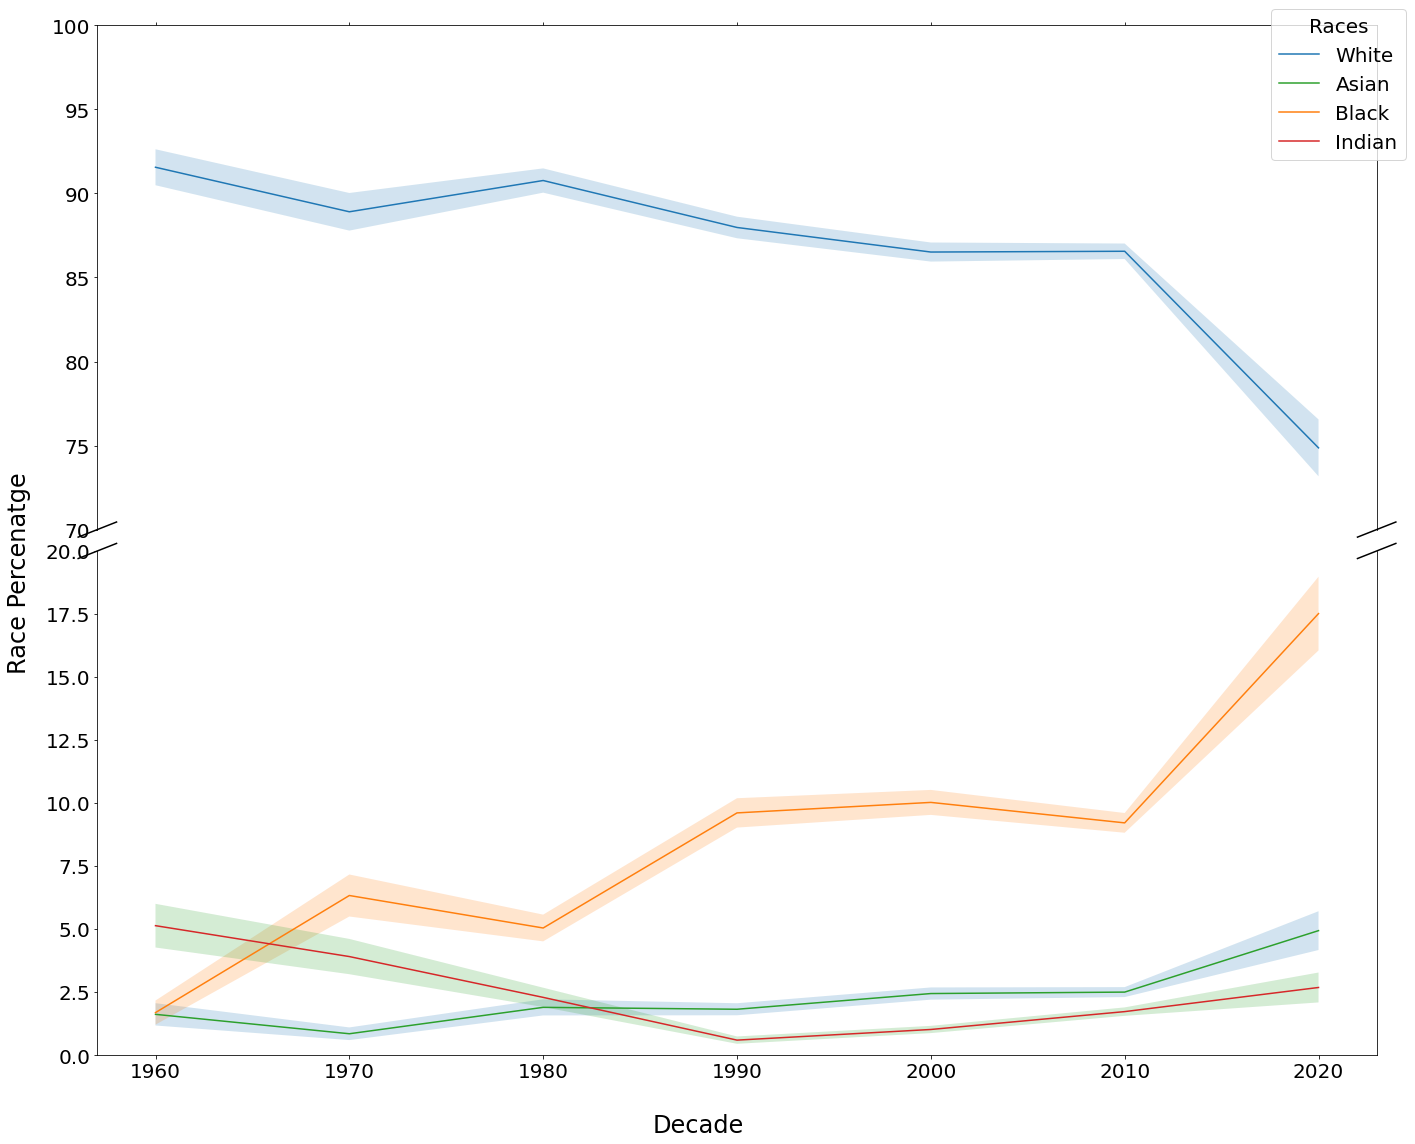

In [41]:
# grouped = poster_face_races_new_encoding.groupby((poster_face_races_new_encoding.startYear//10)*10).sum()
grouped = poster_face_races_new_encoding.groupby(['decade', 'tconst']).sum()

grouped['race_sum'] = grouped['Asian'] + grouped['Black'] + grouped['Indian'] + grouped['White']

grouped['Asian'] = grouped['Asian'] / grouped['race_sum'] * 100
grouped['Black'] = grouped['Black'] / grouped['race_sum'] * 100
grouped['Indian'] = grouped['Indian'] / grouped['race_sum'] * 100
grouped['White'] = grouped['White'] / grouped['race_sum'] * 100
grouped = grouped.reset_index()
# grouped = grouped.set_index("decade")

grouped = grouped[grouped.decade >= 1960]

import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 20))
plt.rcParams.update({'font.size': 20})
import seaborn as sns


##################################
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=figure_size)
# f = plt.figure(figsize=figure_size)
# ax = f.add_subplot(111)    # The big subplot
# fig.add_subplot(111, frameon=False)
f.tight_layout(h_pad=0.1)

# zoom-in / limit the view to different portions of the data
if is_english_movies:
    ax1.set_ylim(70, 100)  # outliers only
    ax2.set_ylim(0, 20)  # most of the data
else:
    ax1.set_ylim(40, 85)  # outliers only
    ax2.set_ylim(0, 40)  # most of the data

# hide the spines between ax and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()


d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# plt.show()
##################################

err = grouped.groupby("decade").sem()
grouped = grouped.groupby("decade").mean()


ax3 = sns.lineplot(data=grouped, x=grouped.index, y="Asian", label='Asian', color=palette['Asian'], ax=ax2)
ax3.fill_between(grouped.index, grouped["Asian"] - err["Asian"], grouped["Asian"] + err["Asian"], alpha=0.2)
ax4 = sns.lineplot(data=grouped, x=grouped.index, y="Black", label='Black', color=palette['Black'], ax=ax2)
ax4.fill_between(grouped.index, grouped["Black"] - err["Black"], grouped["Black"] + err["Black"], alpha=0.2)
ax5 = sns.lineplot(data=grouped, x=grouped.index, y="Indian", label="Indian", color=palette['Indian'], ax=ax2)
ax5.fill_between(grouped.index, grouped["Indian"] - err["Indian"], grouped["Indian"] + err["Indian"], alpha=0.2)
ax6 = sns.lineplot(data=grouped, x=grouped.index, y="White", label="White", color=palette['White'], ax=ax1)
ax6.fill_between(grouped.index, grouped["White"] - err["White"], grouped["White"] + err["White"], alpha=0.2)
ax1.legend('',frameon=False)
ax2.legend('',frameon=False)
ax1.set(xlabel='', ylabel='')
ax2.set(xlabel='', ylabel='')
# ax.set(xlabel='Decade', ylabel='Race Percenatge')
f.legend().set_title('Races')
# plt.xlabel("common X", multialignment='center')
# plt.ylabel("common Y", position='center')
f.supylabel('Race Percenatge')
f.supxlabel('Decade')
f.tight_layout(h_pad=0.1)

# f.text(0.5, 0.04, 'common xlabel', ha='center', va='center')
# f.text(0.06, 0.5, 'common ylabel', ha='center', va='center', rotation='vertical')
# ax1.set(ylabel='')
# ax1.legend( handles=ax3+ax4 )

# y_ticks = [i for i in range(0,20,5)]
# ax2.set_yticks(y_ticks)
# number-faces-percentage-race-decade.png

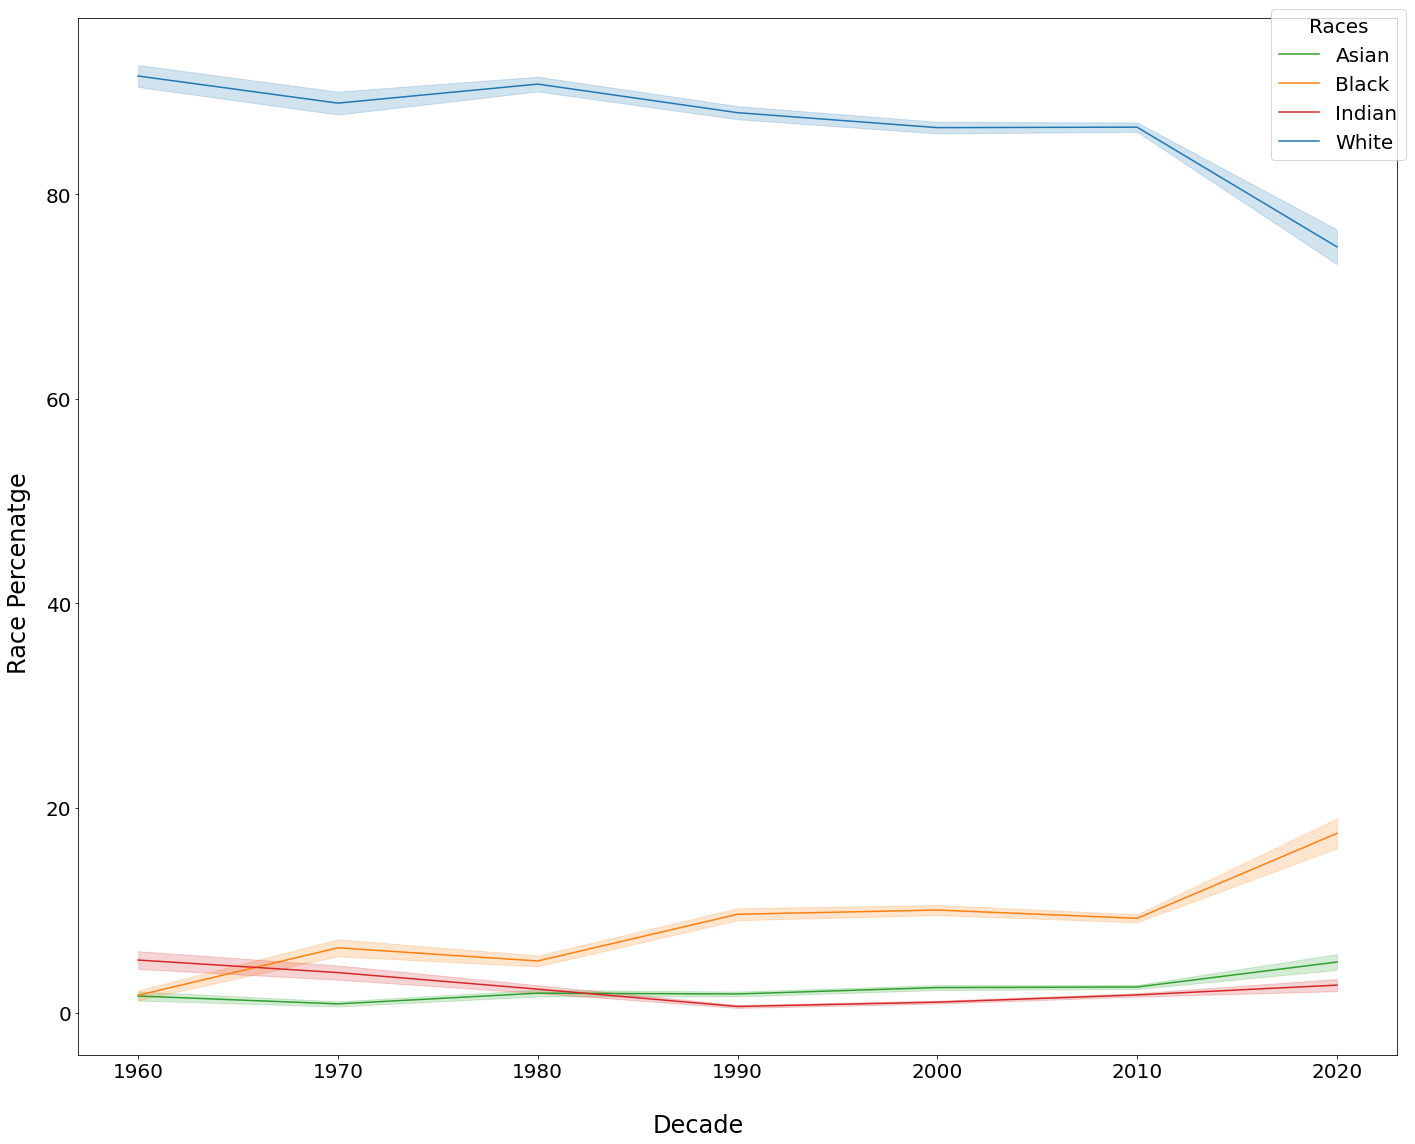

In [42]:
# grouped = poster_face_races_new_encoding.groupby((poster_face_races_new_encoding.startYear//10)*10).sum()
grouped = poster_face_races_new_encoding.groupby(['decade', 'tconst']).sum()

grouped['race_sum'] = grouped['Asian'] + grouped['Black'] + grouped['Indian'] + grouped['White']

grouped['Asian'] = grouped['Asian'] / grouped['race_sum'] * 100
grouped['Black'] = grouped['Black'] / grouped['race_sum'] * 100
grouped['Indian'] = grouped['Indian'] / grouped['race_sum'] * 100
grouped['White'] = grouped['White'] / grouped['race_sum'] * 100
grouped = grouped.reset_index()
# grouped = grouped.set_index("decade")

grouped = grouped[grouped.decade >= 1960]

import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 20))
plt.rcParams.update({'font.size': 20})
import seaborn as sns


##################################
f, ax1 = plt.subplots(1, 1, sharex=True, figsize=figure_size)
# f = plt.figure(figsize=figure_size)
# ax = f.add_subplot(111)    # The big subplot
# fig.add_subplot(111, frameon=False)
f.tight_layout(h_pad=0.1)


# plt.show()
##################################

err = grouped.groupby("decade").sem()
grouped = grouped.groupby("decade").mean()


ax3 = sns.lineplot(data=grouped, x=grouped.index, y="Asian", label='Asian', color=palette['Asian'], ax=ax1)
ax3.fill_between(grouped.index, grouped["Asian"] - err["Asian"], grouped["Asian"] + err["Asian"], color=palette['Asian'], alpha=0.2)
ax4 = sns.lineplot(data=grouped, x=grouped.index, y="Black", label='Black', color=palette['Black'], ax=ax1)
ax4.fill_between(grouped.index, grouped["Black"] - err["Black"], grouped["Black"] + err["Black"], color=palette['Black'], alpha=0.2)
ax5 = sns.lineplot(data=grouped, x=grouped.index, y="Indian", label="Indian", color=palette['Indian'], ax=ax1)
ax5.fill_between(grouped.index, grouped["Indian"] - err["Indian"], grouped["Indian"] + err["Indian"], color=palette['Indian'], alpha=0.2)
ax6 = sns.lineplot(data=grouped, x=grouped.index, y="White", label="White", color=palette['White'], ax=ax1)
ax6.fill_between(grouped.index, grouped["White"] - err["White"], grouped["White"] + err["White"], color=palette['White'], alpha=0.2)
ax1.legend('',frameon=False)
ax1.set(xlabel='', ylabel='')
# ax.set(xlabel='Decade', ylabel='Race Percenatge')
f.legend().set_title('Races')
# plt.xlabel("common X", multialignment='center')
# plt.ylabel("common Y", position='center')
f.supylabel('Race Percenatge')
f.supxlabel('Decade')
f.tight_layout(h_pad=0.1)

# f.text(0.5, 0.04, 'common xlabel', ha='center', va='center')
# f.text(0.06, 0.5, 'common ylabel', ha='center', va='center', rotation='vertical')
# ax1.set(ylabel='')
# ax1.legend( handles=ax3+ax4 )

# y_ticks = [i for i in range(0,20,5)]
# ax2.set_yticks(y_ticks)


# Graph of **race distribution** over **decade** normalized according to USA ethnic distribution 

In [63]:
from collections import Counter

def get_races_counts(row):
  races=row["faces_races"]

  keys = Counter(races).keys()
  counts = [count for count in Counter(races).values()]

  for key, count in zip(keys,counts):
    row[key] = count

  return row

posters_races_counts_df = posters_races_df.apply(get_races_counts, axis = 1).fillna(0).drop([''], axis=1)

In [64]:
posters_races_counts_df['ethnic_count'] = posters_races_counts_df['Asian'] + posters_races_counts_df['Black']+posters_races_counts_df['Indian']+posters_races_counts_df['White']
posters_races_counts_df = posters_races_counts_df[posters_races_counts_df['ethnic_count'] > 0]

def calc_races_ratio(row):
  row['Asian'] = row['Asian'] / (row['ethnic_count'])*100
  row['Black'] = row['Black'] / (row['ethnic_count'])*100
  row['Indian'] = row['Indian'] / (row['ethnic_count'])*100
  row['White'] = row['White'] / (row['ethnic_count'])*100

  return row

posters_races_counts_df = posters_races_counts_df.apply(calc_races_ratio, axis=1)

/tmp/ipykernel_103023/519474354.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  races_by_decade_normalize['startYear'] = races_by_decade_normalize.startYear//10*10
/tmp/ipykernel_103023/519474354.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  races_by_decade_normalize["Indian-Asian"] = races_by_decade_normalize["Indian"] + races_by_decade_normalize["Asian"]


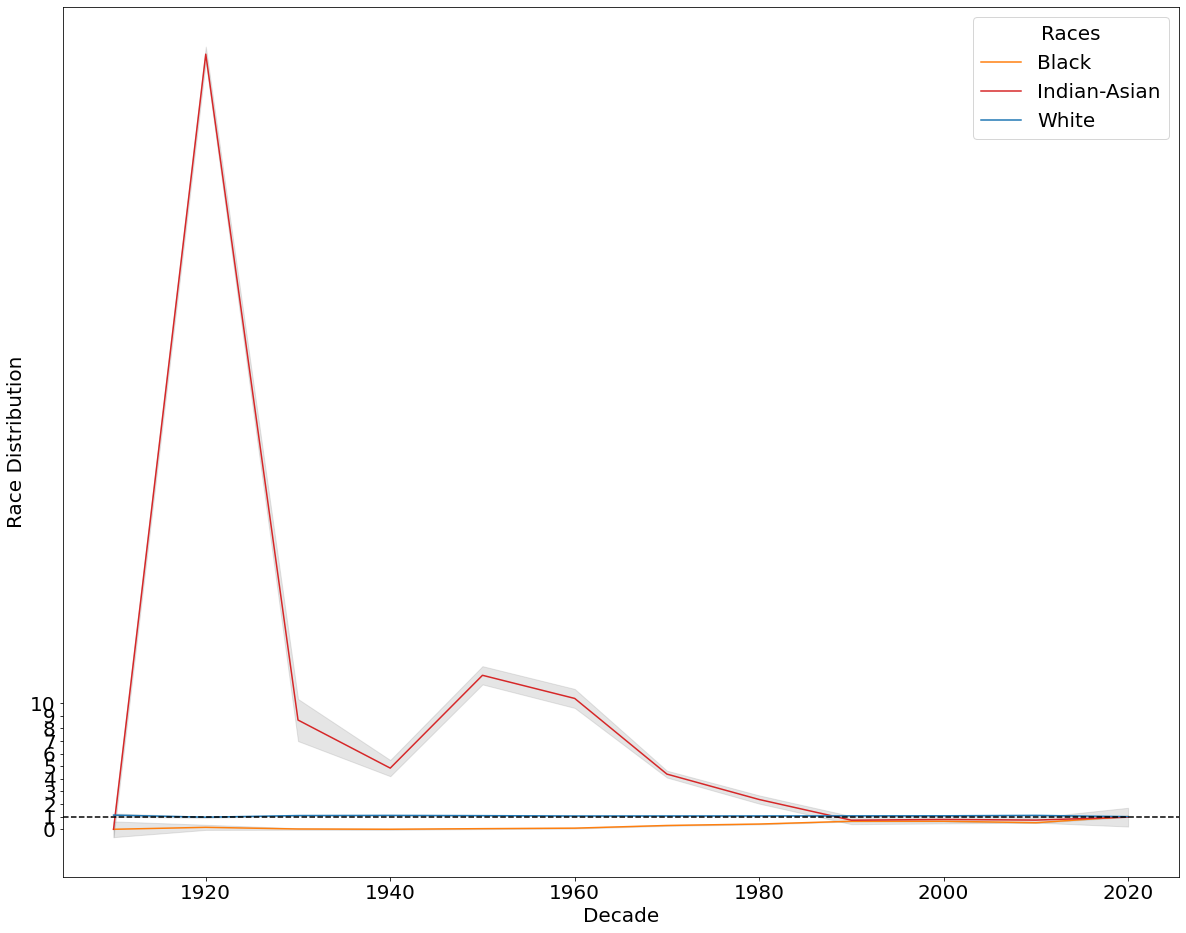

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=figure_size)
plt.rcParams.update({'font.size': 20})

import seaborn as sns
import numpy as np

actual_decades = pd.DataFrame({
    "startYear": [1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020],
    "White-actual":[88.9,89.7,89.8,89.8,89.5,88.6,87.7,83.1,80.3,75.1,72.4,61.6],
    "Black-actual":[10.7,9.9,9.7,9.8,10.0,10.5,11.1,11.7,12.1,12.3,12.6,12.4],
    "Asian-actual":[0.2,0.2,0.2,0.2,0.2,0.5,0.8,1.5,2.9,3.8,4.9,6.2]
})

actual_decades['sum'] = actual_decades['White-actual'] + actual_decades['Black-actual'] + actual_decades['Asian-actual']
actual_decades['White-actual'] = (actual_decades['White-actual']/actual_decades['sum'])*100
actual_decades['Black-actual'] = (actual_decades['Black-actual']/actual_decades['sum'])*100
actual_decades['Asian-actual'] = (actual_decades['Asian-actual']/actual_decades['sum'])*100

races_by_decade_normalize = posters_races_counts_df[["White", "Black", "Indian", "Asian", "startYear"]]
races_by_decade_normalize['startYear'] = races_by_decade_normalize.startYear//10*10
races_by_decade_normalize["Indian-Asian"] = races_by_decade_normalize["Indian"] + races_by_decade_normalize["Asian"]

races_by_decade_normalize = races_by_decade_normalize[["White", "Black", "Indian-Asian", "startYear"]].merge(actual_decades, on="startYear")

races_by_decade_normalize["White"] = races_by_decade_normalize["White"] / races_by_decade_normalize["White-actual"]
races_by_decade_normalize["Black"] = races_by_decade_normalize["Black"] / races_by_decade_normalize["Black-actual"]
races_by_decade_normalize["Indian-Asian"] = races_by_decade_normalize["Indian-Asian"] / races_by_decade_normalize["Asian-actual"]

races_sems = races_by_decade_normalize.groupby((posters_races_counts_df.startYear//10)*10).sem()[["White", "Black", "Indian-Asian"]]
races_by_decade_normalize = races_by_decade_normalize.groupby((races_by_decade_normalize.startYear//10)*10).mean()

races_by_decade_normalize = races_by_decade_normalize.set_index(races_by_decade_normalize.startYear)

# races_by_decade_normalize[["White", "Black", "Indian-Asian"]] = np.log(races_by_decade_normalize[["White", "Black", "Indian-Asian"]])

# races_by_decade_normalize = races_by_decade_normalize[races_by_decade_normalize['startYear']>=1990]
# races_sems = races_sems[races_sems.index>=1990]

ax = sns.lineplot(data=races_by_decade_normalize, x=races_by_decade_normalize.startYear, y="Black", label='Black', color=palette['Black'])
sns.lineplot(data=races_by_decade_normalize, x=races_by_decade_normalize.startYear, y="Indian-Asian", label="Indian-Asian", color=palette['Indian'])
sns.lineplot(data=races_by_decade_normalize, x=races_by_decade_normalize.startYear, y="White", label="White", color=palette['White'])
ax.set(xlabel='Decade', ylabel='Race Distribution')
ax.legend().set_title('Races')

xfit = races_by_decade_normalize['startYear']

black = races_by_decade_normalize['Black']
plt.fill_between(xfit, black - races_sems['Black'], black + races_sems['Black'],
                 color='gray', alpha=0.2)

white = races_by_decade_normalize['White']
plt.fill_between(xfit, white - races_sems['White'], white + races_sems['White'],
                 color='gray', alpha=0.2)

indian_asian = races_by_decade_normalize['Indian-Asian']
plt.fill_between(xfit, indian_asian - races_sems['Indian-Asian'], indian_asian + races_sems['Indian-Asian'],
                 color='gray', alpha=0.2)

y_ticks = [i for i in range(0,11,1)]
ax.set_yticks(y_ticks)

# x_ticks = [i for i in range(1990,2030,10)]
# ax.set_xticks(x_ticks)

ax.axhline(1, ls='--', color='black')

# Get Actors Ranking

# Prepare Ranking For Graphs

In [43]:
posters_for_ranking_graphs['decade'] = (posters_for_ranking_graphs['startYear']//10)*10

ranking_decade_count = posters_for_ranking_graphs.groupby(['actor_rank', 'decade']).count()[['movie']]
ranking_decade_count['count'] = ranking_decade_count['movie']
ranking_decade_count = ranking_decade_count[['count']]
# ranking_count = ranking_count.reset_index()
# ranking_decade_count

## Race Ratio Over Rank By Each Race

In [44]:
ranking_count = posters_for_ranking_graphs.groupby('actor_rank').count()[['movie']]
ranking_count['count'] = ranking_count['movie']
ranking_count = ranking_count[['count']]
ranking_count = ranking_count[ranking_count.index<=12]

<Figure size 1440x1152 with 0 Axes>

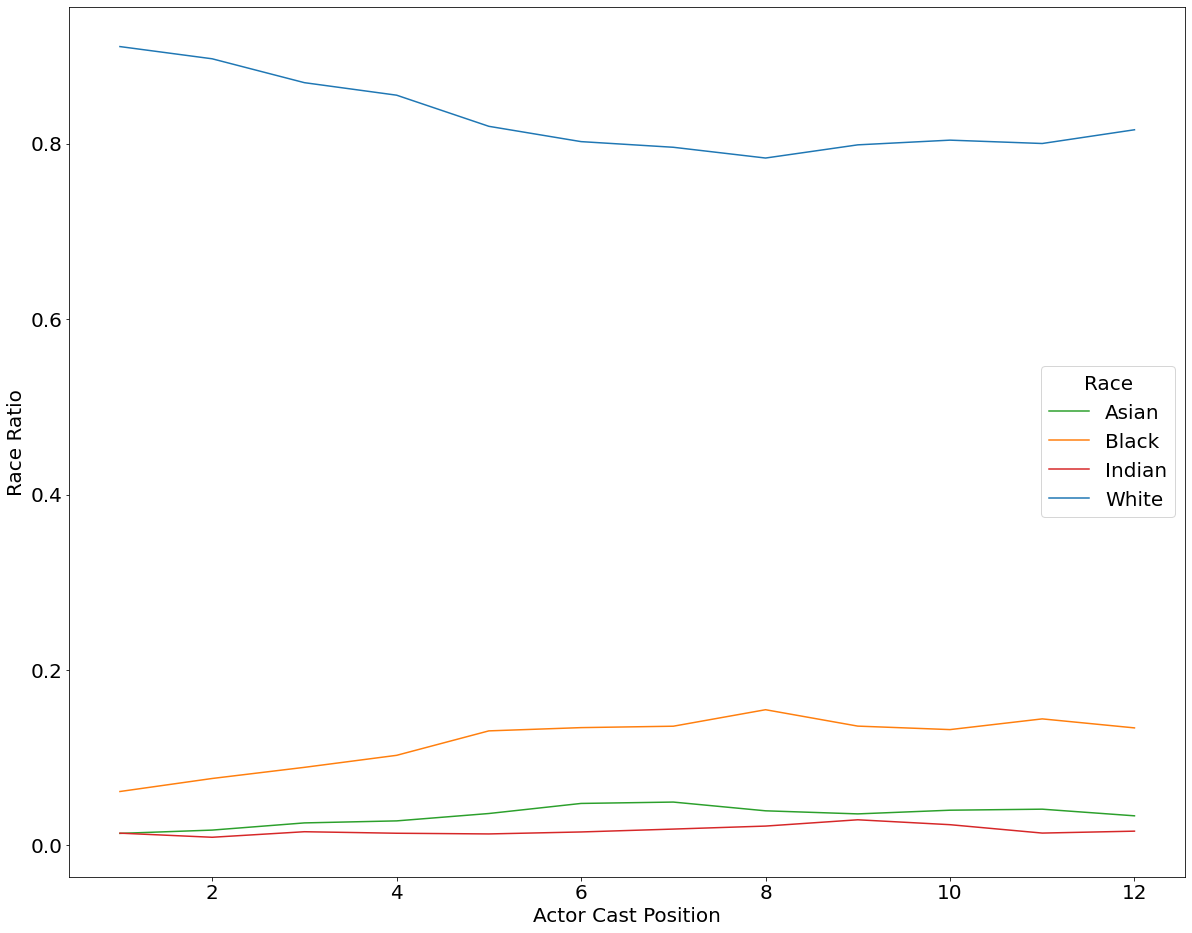

In [45]:
posters_for_ranking_graphs_count = posters_for_ranking_graphs.groupby(['face_race', 'actor_rank']).count()
posters_for_ranking_graphs_count['count'] = posters_for_ranking_graphs_count['movie']
posters_for_ranking_graphs_count = posters_for_ranking_graphs_count[['count']]
posters_for_ranking_graphs_count = posters_for_ranking_graphs_count.reset_index()
posters_for_ranking_graphs_count = posters_for_ranking_graphs_count.merge(ranking_count, on=['actor_rank'])
posters_for_ranking_graphs_count['ratio'] = posters_for_ranking_graphs_count['count_x'] / posters_for_ranking_graphs_count['count_y']

import matplotlib.pyplot as plt

plt.figure(figsize=figure_size)
plt.rcParams.update({'font.size': 20})

import seaborn as sns
from matplotlib import pyplot

a4_dims = figure_size
fig, ax = pyplot.subplots(figsize=a4_dims)

a = sns.lineplot(x="actor_rank", hue="face_race", data=posters_for_ranking_graphs_count ,ax=ax, y='ratio', hue_order=hue_order, palette=palette)
a.set(xlabel='Actor Cast Position', ylabel='Race Ratio')
ax.legend(title = 'Race')
# ax.set(ylim=(0, 1))

<Figure size 1440x1152 with 0 Axes>

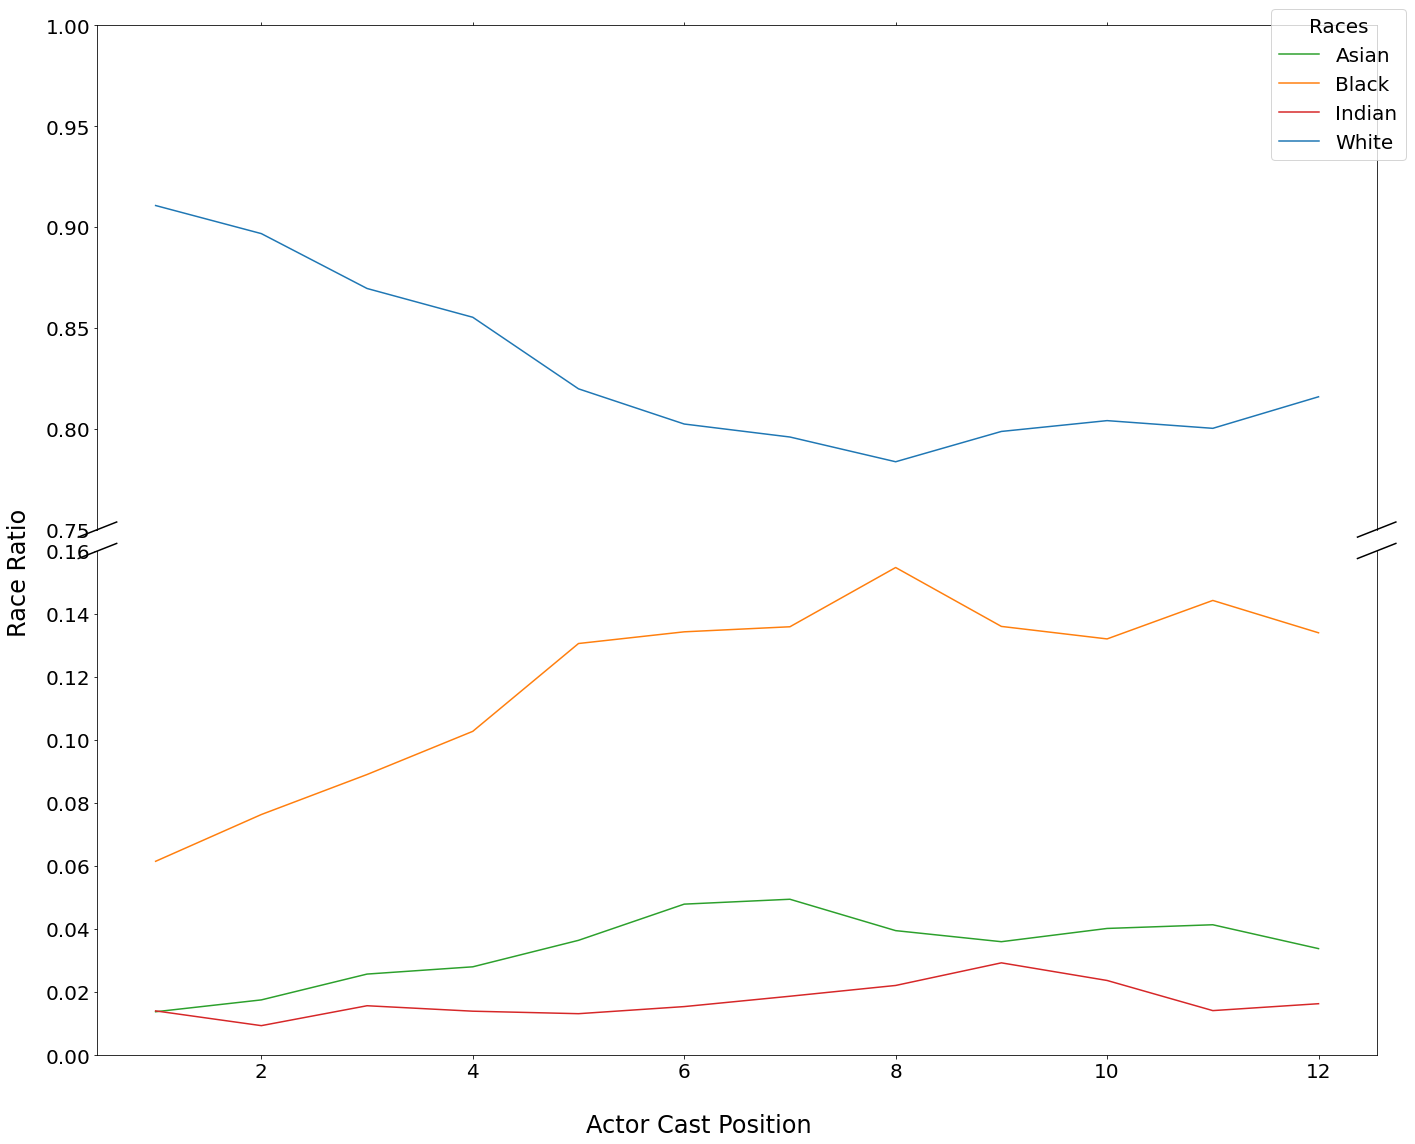

In [47]:
posters_for_ranking_graphs_count = posters_for_ranking_graphs.groupby(['face_race', 'actor_rank']).count()
posters_for_ranking_graphs_count['count'] = posters_for_ranking_graphs_count['movie']
posters_for_ranking_graphs_count = posters_for_ranking_graphs_count[['count']]
posters_for_ranking_graphs_count = posters_for_ranking_graphs_count.reset_index()
posters_for_ranking_graphs_count = posters_for_ranking_graphs_count.merge(ranking_count, on=['actor_rank'])
posters_for_ranking_graphs_count['ratio'] = posters_for_ranking_graphs_count['count_x'] / posters_for_ranking_graphs_count['count_y']

import matplotlib.pyplot as plt

plt.figure(figsize=figure_size)
plt.rcParams.update({'font.size': 20})

import seaborn as sns
from matplotlib import pyplot

# a4_dims = (11.7, 8.27)
# fig, ax = pyplot.subplots(figsize=a4_dims)

##################################
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=figure_size)
f.tight_layout(h_pad=0.1)

# zoom-in / limit the view to different portions of the data
if is_english_movies:
    ax1.set_ylim(0.75, 1)  # outliers only
    ax2.set_ylim(0, 0.16)  # most of the data
else:
    ax1.set_ylim(0.5, 0.65)  # outliers only
    ax2.set_ylim(0, 0.35)  # most of the data

# hide the spines between ax and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()


d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# plt.show()
##################################

a = sns.lineplot(x="actor_rank", hue="face_race", data=posters_for_ranking_graphs_count[posters_for_ranking_graphs_count['face_race'] == 'White'] ,ax=ax1, y='ratio', hue_order=hue_order, palette=palette, legend=False)
a = sns.lineplot(x="actor_rank", hue="face_race", data=posters_for_ranking_graphs_count[posters_for_ranking_graphs_count['face_race'] != 'White'] ,ax=ax2, y='ratio', hue_order=hue_order, palette=palette)

ax1.legend('',frameon=False)
ax2.legend('',frameon=False)
ax1.set(xlabel='', ylabel='')
ax2.set(xlabel='', ylabel='')

f.legend().set_title('Races')
# plt.xlabel("common X", multialignment='center')
# plt.ylabel("common Y", position='center')
f.supylabel('Race Ratio')
f.supxlabel('Actor Cast Position')
f.tight_layout(h_pad=0.1)
# ax2.set(ylim=(0, 1))

## Rank Histogram

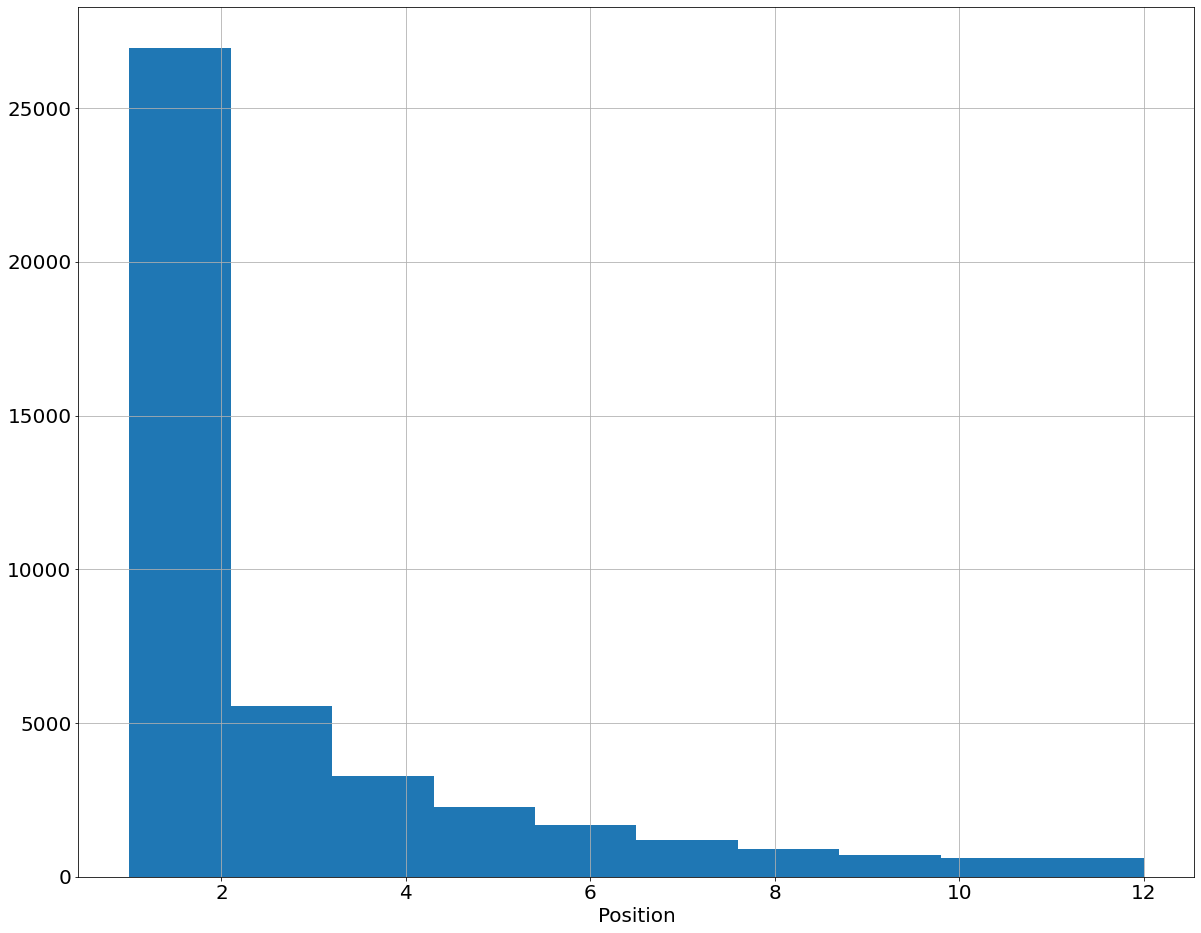

In [38]:
rank_hist = posters_for_ranking_graphs[posters_for_ranking_graphs['actor_rank']<=12].hist(column='actor_rank', figsize=figure_size)

import pylab as pl
pl.title("")

import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 20})

for ax in rank_hist.flatten():
    ax.set_xlabel("Position")

# Analysis By Categories

In [109]:
poster_exploded_genres = poster_face_races_new_encoding.explode("faces_races").explode("genres")
poster_exploded_genres = poster_exploded_genres[poster_exploded_genres["faces_races"]!=""]
# poster_exploded_genres = poster_exploded_genres[poster_exploded_genres["startYear"]>2000] # filter by year
race_genere = poster_exploded_genres.groupby(["faces_races","genres", "tconst","file_path"]).count()

In [110]:
race_genere = race_genere.groupby(["faces_races","genres", "tconst"]).mean()

In [111]:
piv = race_genere.pivot_table(values="faces_count",index=["genres", "tconst"], columns=["faces_races"])


In [112]:
piv = piv.fillna(0)

In [113]:
# piv = race_genere.groupby(["faces_races","genres"]).mean().pivot_table(values="faces_count",index="genres", columns=["faces_races", "tconst"])
piv["sum"]= piv["Asian"]+piv["Black"]+piv["Indian"]+piv["White"]
piv["Asian"] = piv["Asian"]/piv["sum"]
piv["Black"] = piv["Black"]/piv["sum"]
piv["Indian"] = piv["Indian"]/piv["sum"]
piv["White"] = piv["White"]/piv["sum"]

# piv = piv.dropna()
# piv['sum'] = piv['sum'].astype(int)

In [114]:
piv = piv.groupby("genres").mean()

## Only Genres Sums

In [115]:
piv = piv[piv["Asian"] > 0]

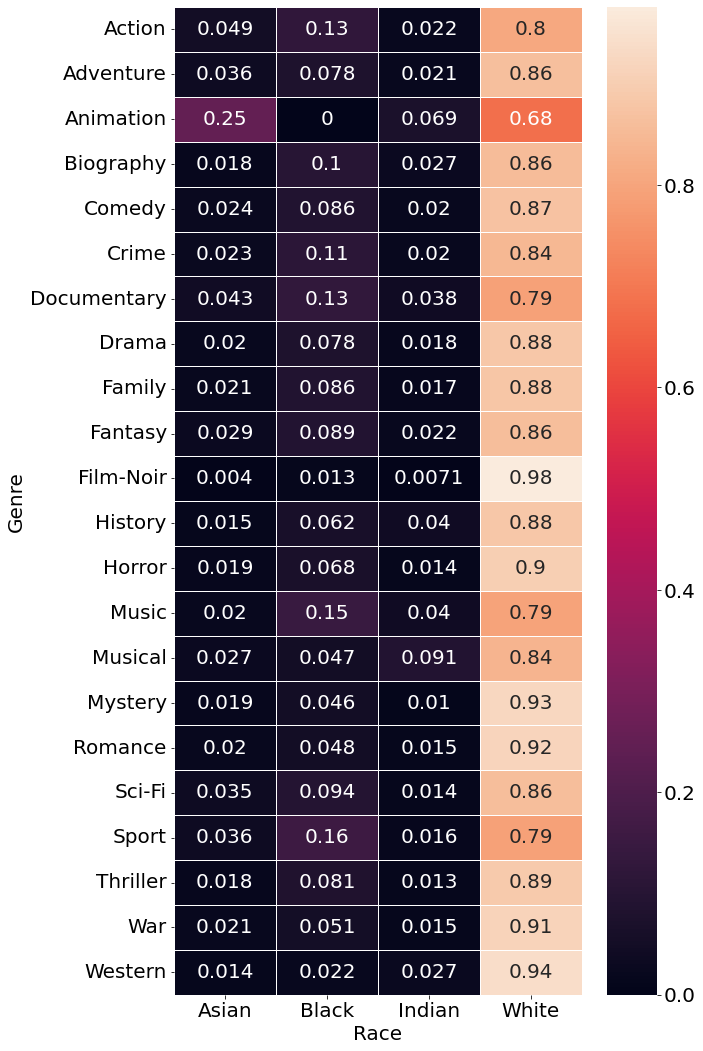

In [116]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(10,15))

# fig, axes = plt.subplots(1, 1, figsize=(15, 10), sharey=False, gridspec_kw={'width_ratios': [6, 1]}, )

sns.heatmap(piv.drop(columns="sum"), xticklabels=True, yticklabels=True, annot=True, linewidths=.5, ax=ax)
ax.set(xlabel='Race', ylabel='Genre')

# sns.heatmap(piv[['sum']], xticklabels=False, yticklabels=True, annot=True, fmt='d', linewidths=.5, ax=axes[1], cbar=False)
# axes[1].set(xlabel='Total', ylabel='')

fig.tight_layout()

# Ethnic By genre

In [117]:
piv = race_genere.pivot_table(values="faces_count",index=["genres", "tconst"], columns="faces_races")


In [118]:
piv = piv.fillna(0)
piv = piv.groupby("genres").sum()

In [119]:
piv = piv.dropna()
piv = piv[piv["Asian"] > 0]

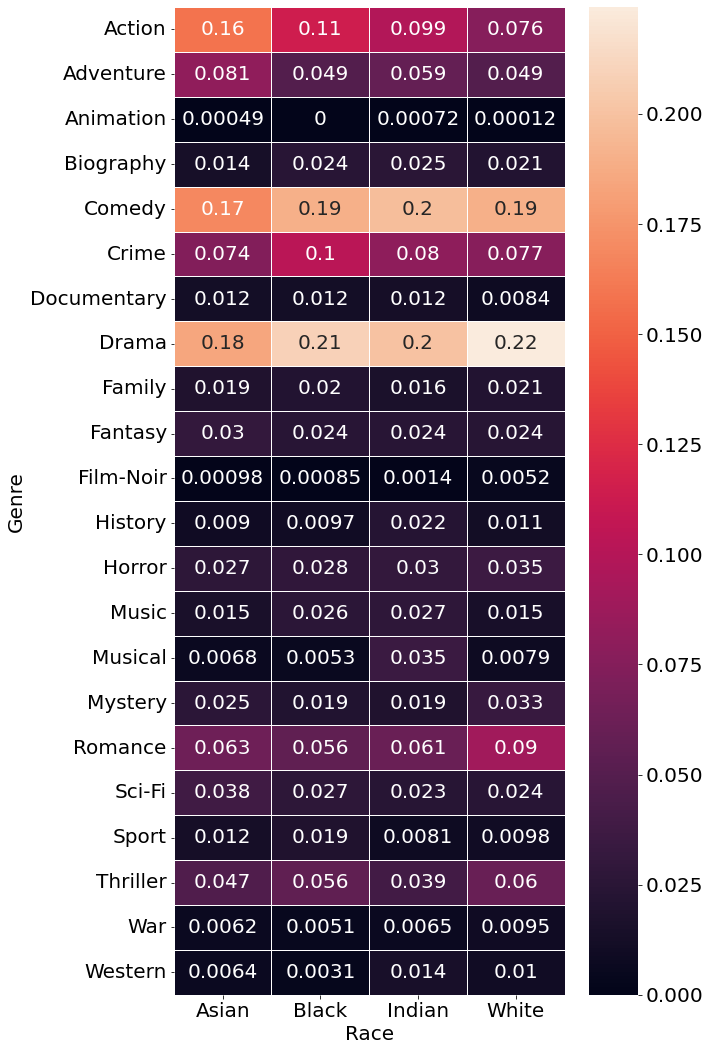

In [120]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(10,15))
# plt.rcParams.update({'font.size': 16})
# fig, ax = plt.subplots(figsize=(1,10))
df_norm_row = piv.T.apply(lambda x: x/x.sum(), axis = 1)


# fig, axes = plt.subplots(1, 1, figsize=(20, 15), sharey=False, gridspec_kw={'width_ratios': [6, 1]}, )

sns.heatmap(df_norm_row.loc[["Asian","Black","Indian","White"]].T, xticklabels=True, yticklabels=True, annot=True, linewidths=.5)
ax.set(xlabel='Race', ylabel='Genre')

# sns.heatmap(piv[['sum']], xticklabels=False, yticklabels=True, annot=True, fmt='d', linewidths=.5, ax=axes[1], cbar=False)
# axes[1].set(xlabel='Total', ylabel='')

fig.tight_layout()

In [121]:
!zip -r figures.zip figures

  adding: figures/ (stored 0%)
  adding: figures/number-faces-percentage-race-decade.png (deflated 8%)
  adding: figures/relative-face-percentage-decade.png (deflated 4%)
  adding: figures/distance-from-center.png (deflated 5%)
  adding: figures/unique-face-race.png (deflated 2%)
  adding: figures/second-prob.png (deflated 2%)
  adding: figures/race-ratio-actor-rank.png (deflated 13%)
  adding: figures/genre-races.png (deflated 5%)
